In [1]:
import os

import pandas as pd
from utils import uniform_split, plot_df_language_distribution, get_indexes_per_language, plot_language_distribution, get_client_weights, FedAlgo, label_df
from federate import federated_train
import torch

# from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.7.0+cu118


'cuda'

In [2]:
MODEL_PATH = "mBERT" # I have donloaded distilled mBERT (hugggingface not available in China)
# MODEL_PATH = "distilbert-base-multilingual-cased"
DATA_DIR = "data"
seed = 42

In [3]:
portion = 0.1
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv")).sample(frac=portion, random_state=seed)
val_df = pd.read_csv(os.path.join(DATA_DIR, "validation.csv")).sample(frac=portion, random_state=seed)
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv")).sample(frac=portion, random_state=seed)
languages = list(train_df.language.unique())

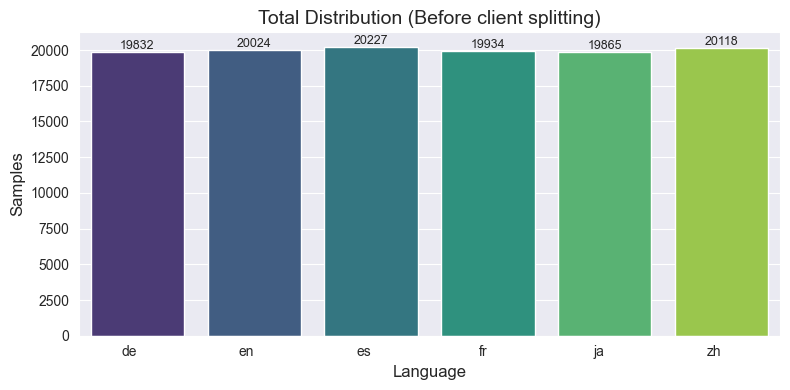

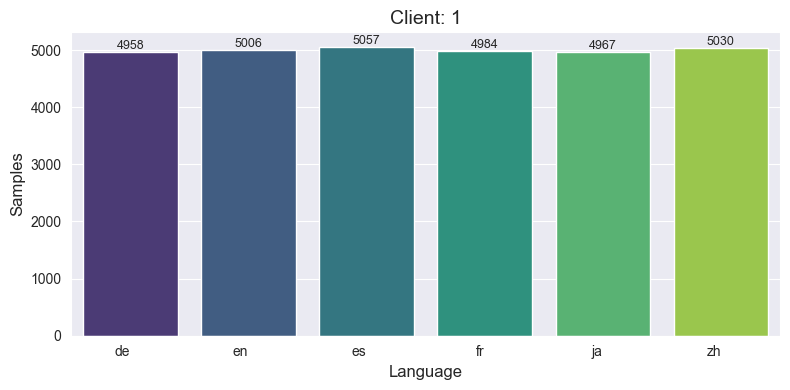

In [8]:
lang_to_indices = get_indexes_per_language(train_df)
plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
plot_language_distribution([uniform_split(train_df, lang_to_indices.copy(), seed=42)[0]], languages)

In [4]:
# ==== Tokenizer ====
print("Loading tokenizer from local path...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(example):
    return tokenizer(example["review_body"], truncation=True, padding="max_length",max_length=512)

val_ds = label_df(val_df)
test_ds = label_df(test_df)

val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label"]
val_ds.set_format(type="torch", columns=columns_to_keep)
test_ds.set_format(type="torch", columns=columns_to_keep)

Loading tokenizer from local path...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [5]:
from utils import dirichlet_split

def get_client_datasets(beta):
    client_datasets = []
    if beta == -1:
        client_dfs = uniform_split(train_df, lang_to_indices.copy(), seed=seed)
    else:
        client_dfs = dirichlet_split(train_df, lang_to_indices, beta=beta, seed=seed)
    plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
    plot_language_distribution(client_dfs, languages)
    for client in client_dfs:
        curr = label_df(client).map(tokenize, batched=True)
        curr.set_format(type="torch", columns=columns_to_keep)
        client_datasets.append(curr)
    return client_datasets

In [6]:
NUM_LABELS = 3

# ==== Load Model ====
print("Loading model from local path...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

# ==== Metrics ====
BATCH_SIZE = 32
EPOCHS = 3

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at mBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from local path...


## Experiments

### FedAvg

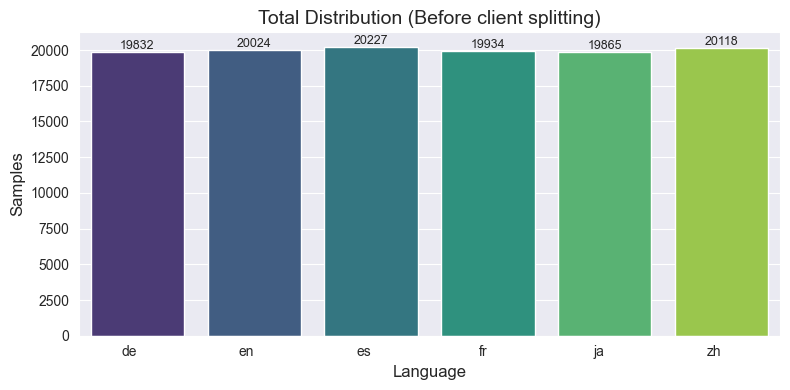

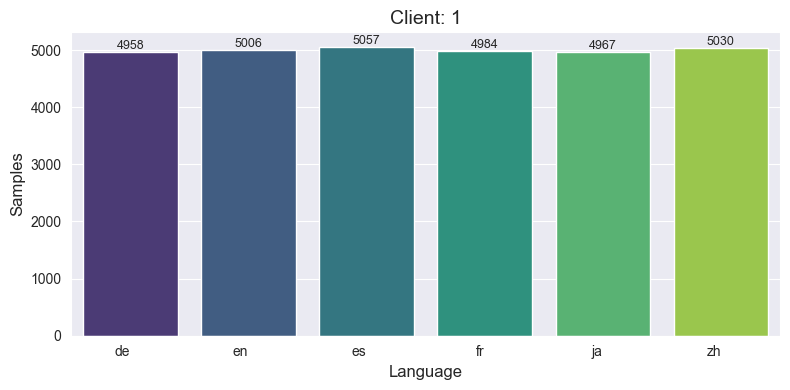

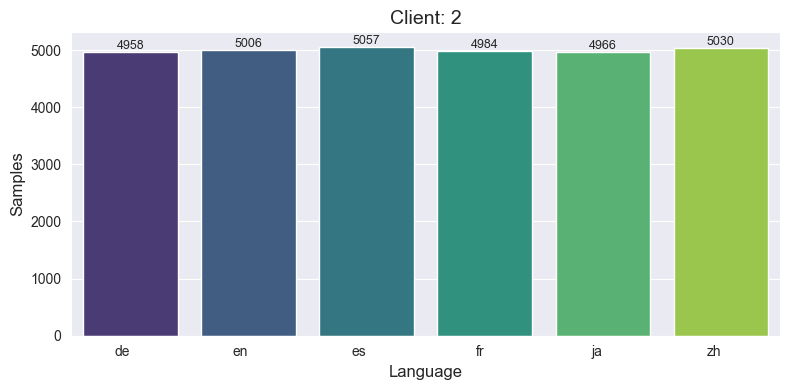

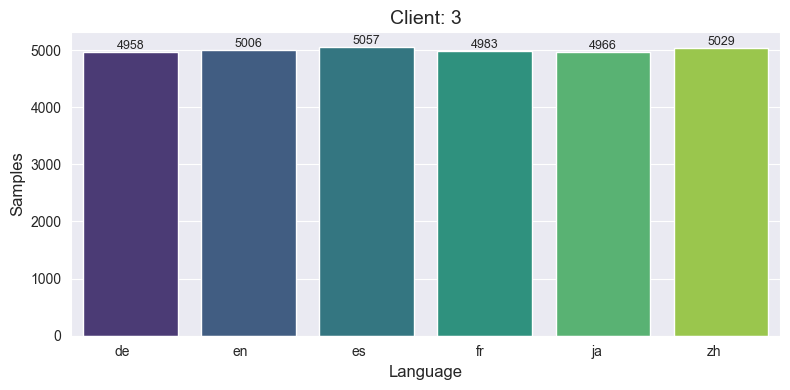

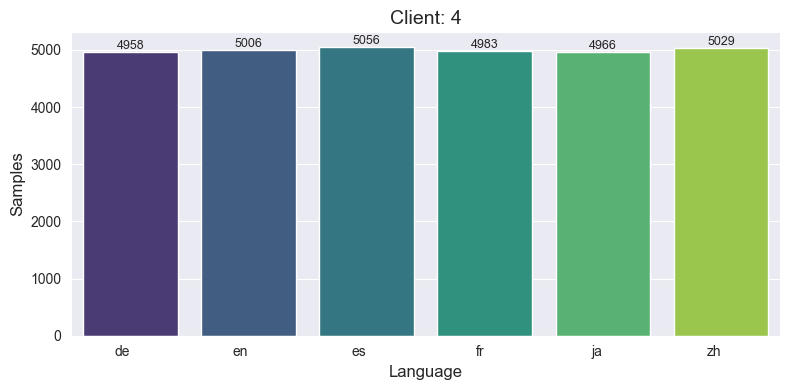

Map:   0%|          | 0/30002 [00:00<?, ? examples/s]

Map:   0%|          | 0/30001 [00:00<?, ? examples/s]

Map:   0%|          | 0/29999 [00:00<?, ? examples/s]

Map:   0%|          | 0/29998 [00:00<?, ? examples/s]


--- Global Round 1/3 ---
 Evaluating global model before client updates...
{'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6013, 'eval_samples_per_second': 651.988, 'eval_steps_per_second': 20.429}
 Global Evaluation (Round 1): {'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6013, 'eval_samples_per_second': 651.988, 'eval_steps_per_second': 20.429}
 Training on Client 1/4...
{'loss': 0.7807, 'grad_norm': 9.4133939743042, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'loss': 0.5698, 'grad_norm': 7.274504661560059, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 312.1597, 'train_samples_per_second': 192.222, 'train_steps_per_second': 6.01, 'train_loss': 0.6752334952608608, 'epoch': 2.0}
 Training on Client 2/4...
{'loss': 0.7792, 'grad_norm': 5.055882930755615, 'learning_rate': 2.5e-05, 'epoch':

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [8]:
# Uniform - FedAvg
run_name = "FedAvg_uniform"
client_datasets = get_client_datasets(beta=-1)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

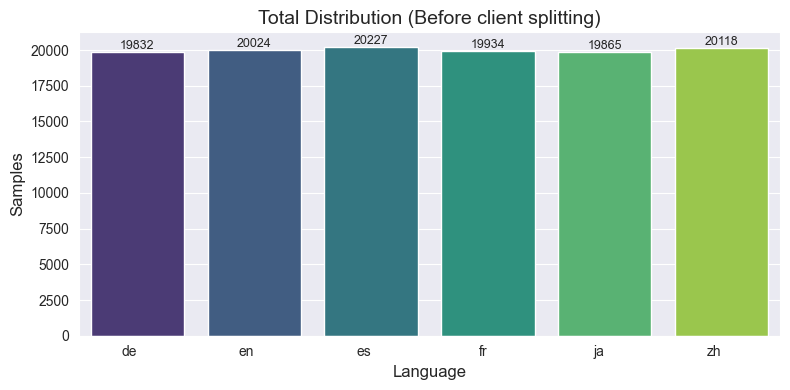

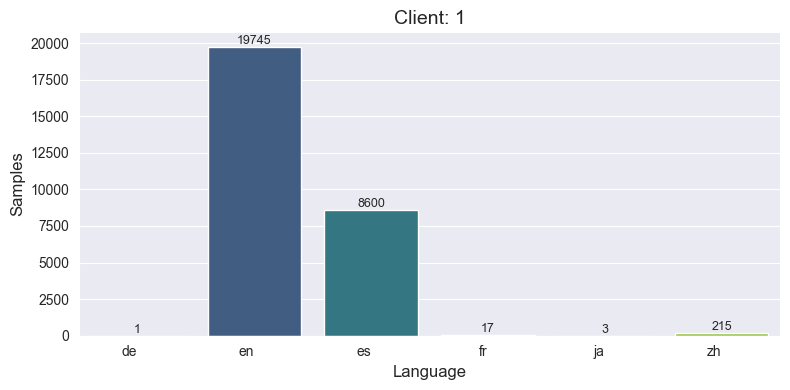

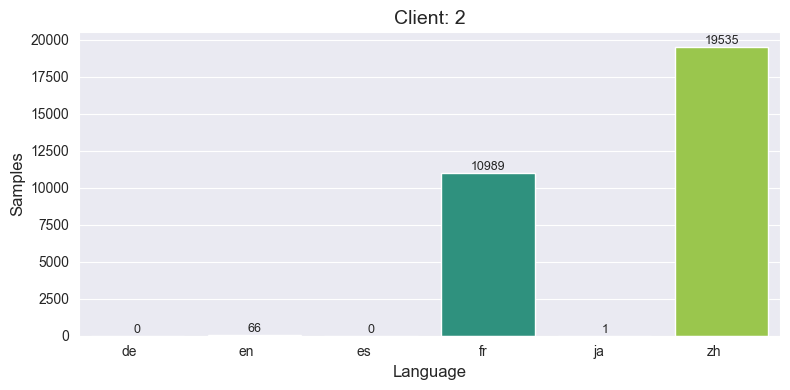

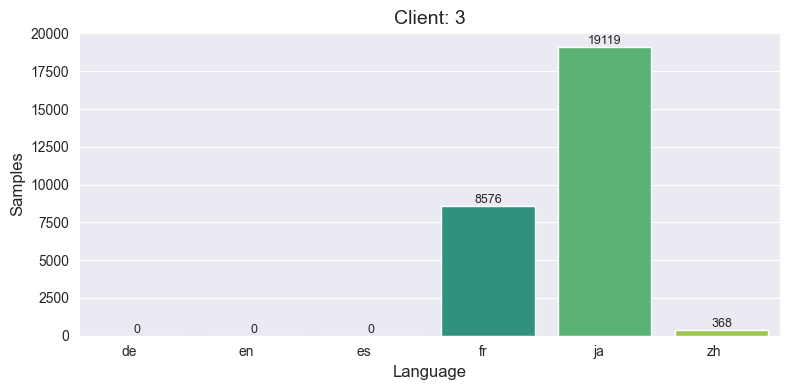

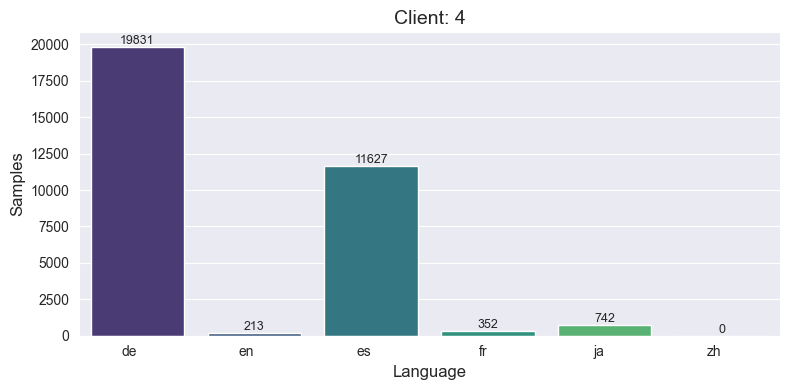

Map:   0%|          | 0/28581 [00:00<?, ? examples/s]

Map:   0%|          | 0/30591 [00:00<?, ? examples/s]

Map:   0%|          | 0/28063 [00:00<?, ? examples/s]

Map:   0%|          | 0/32765 [00:00<?, ? examples/s]


--- Global Round 1/3 ---
 Evaluating global model before client updates...
{'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.9504, 'eval_samples_per_second': 606.015, 'eval_steps_per_second': 18.988}
 Global Evaluation (Round 1): {'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.9504, 'eval_samples_per_second': 606.015, 'eval_steps_per_second': 18.988}
 Training on Client 1/4...
{'loss': 0.7139, 'grad_norm': 13.469049453735352, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'loss': 0.5207, 'grad_norm': 5.298079490661621, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 297.0154, 'train_samples_per_second': 192.455, 'train_steps_per_second': 6.02, 'train_loss': 0.617327065009132, 'epoch': 2.0}
 Training on Client 2/4...
{'loss': 0.7717, 'grad_norm': 4.437442779541016, 'learning_rate': 2.5e-05, 'epoch

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [9]:
# Beta - 0.1, FedAvg
run_name = "FedAvg_b01"
client_datasets = get_client_datasets(beta=0.1)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

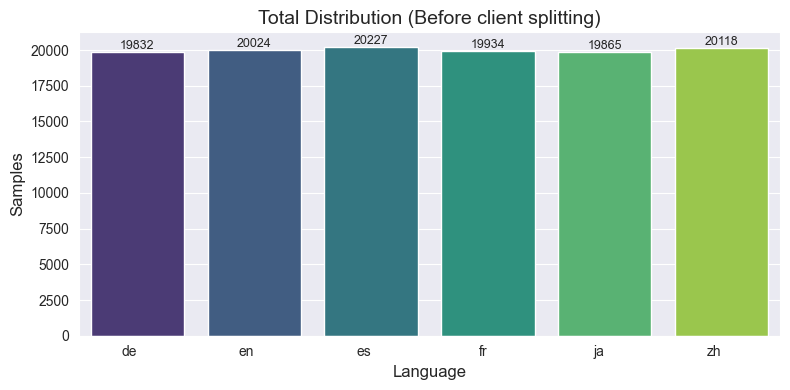

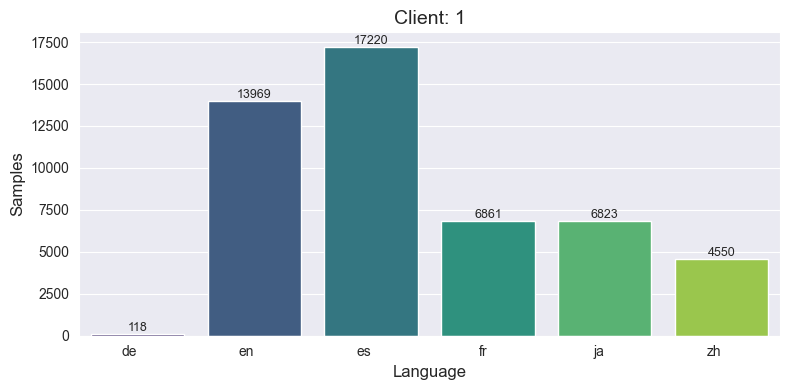

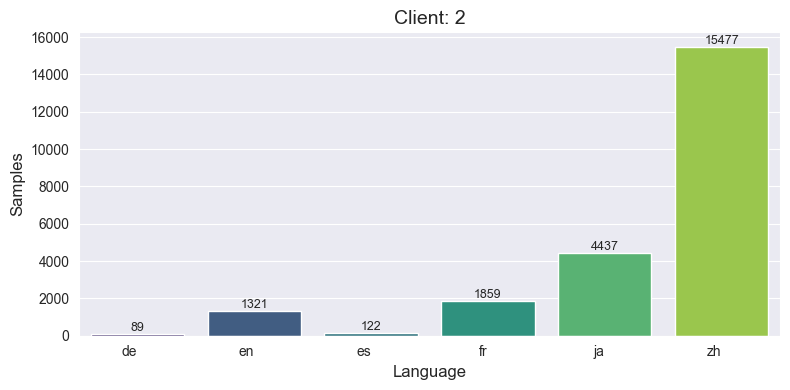

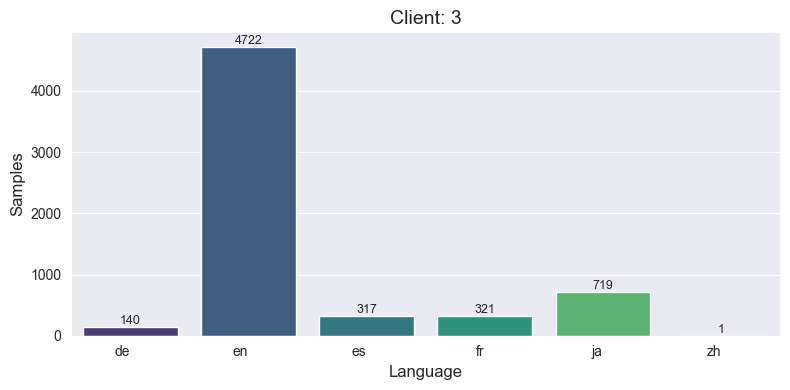

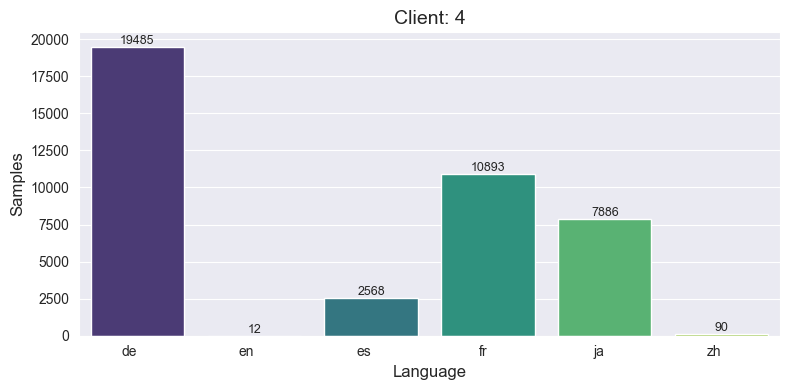

Map:   0%|          | 0/49541 [00:00<?, ? examples/s]

Map:   0%|          | 0/23305 [00:00<?, ? examples/s]

Map:   0%|          | 0/6220 [00:00<?, ? examples/s]

Map:   0%|          | 0/40934 [00:00<?, ? examples/s]


--- Global Round 1/3 ---
 Evaluating global model before client updates...
{'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6184, 'eval_samples_per_second': 649.574, 'eval_steps_per_second': 20.353}
 Global Evaluation (Round 1): {'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6184, 'eval_samples_per_second': 649.574, 'eval_steps_per_second': 20.353}
 Training on Client 1/4...
{'loss': 0.726, 'grad_norm': 7.302901744842529, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'loss': 0.5446, 'grad_norm': 12.022109985351562, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 501.1837, 'train_samples_per_second': 197.696, 'train_steps_per_second': 6.181, 'train_loss': 0.6353141730488925, 'epoch': 2.0}
 Training on Client 2/4...
{'loss': 0.8219, 'grad_norm': 10.722028732299805, 'learning_rate': 2.5e-05, 'epo

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [10]:
# Beta - 0.5, FedAvg
run_name = "FedAvg_b05"
client_datasets = get_client_datasets(beta=0.5)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

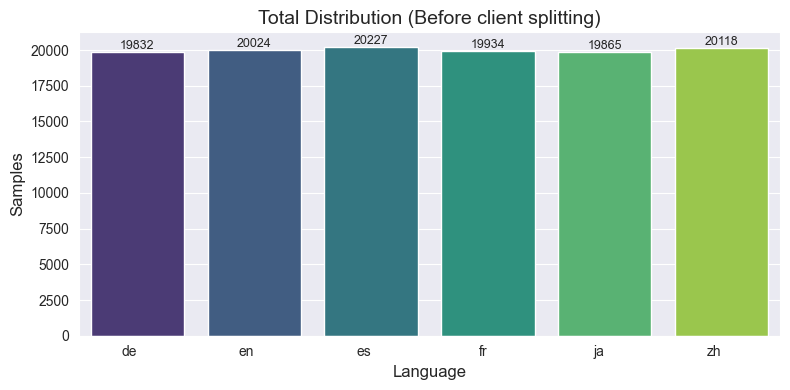

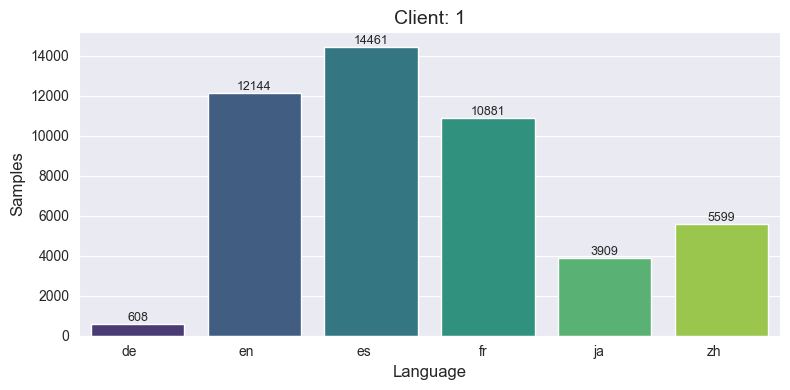

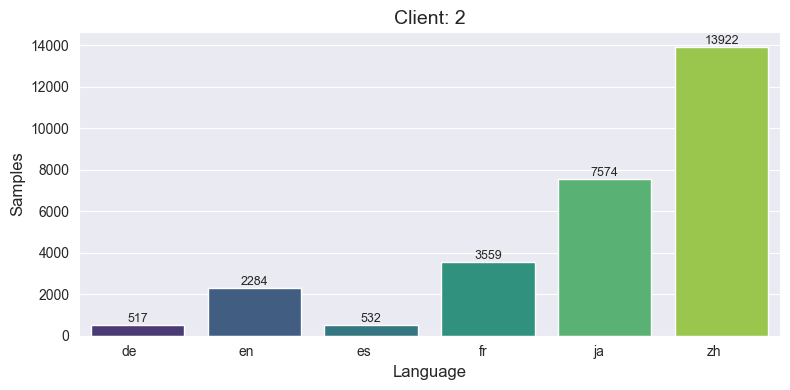

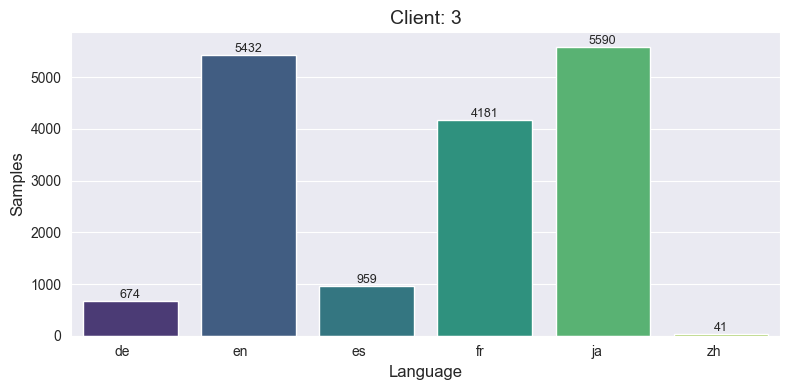

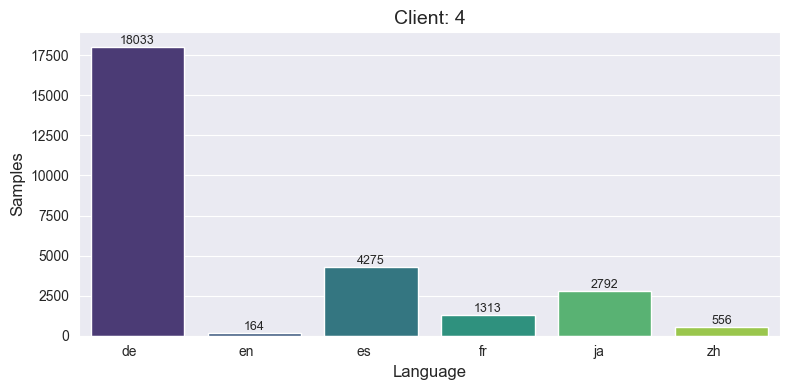

Map:   0%|          | 0/47602 [00:00<?, ? examples/s]

Map:   0%|          | 0/28388 [00:00<?, ? examples/s]

Map:   0%|          | 0/16877 [00:00<?, ? examples/s]

Map:   0%|          | 0/27133 [00:00<?, ? examples/s]


--- Global Round 1/3 ---
 Evaluating global model before client updates...
{'eval_loss': 1.0968689918518066, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.36, 'eval_f1': 0.3454241004013904, 'eval_runtime': 4.7771, 'eval_samples_per_second': 627.998, 'eval_steps_per_second': 19.677}
 Global Evaluation (Round 1): {'eval_loss': 1.0968689918518066, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.36, 'eval_f1': 0.3454241004013904, 'eval_runtime': 4.7771, 'eval_samples_per_second': 627.998, 'eval_steps_per_second': 19.677}
 Training on Client 1/4...
{'loss': 0.7266, 'grad_norm': 7.325095176696777, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'loss': 0.5393, 'grad_norm': 5.346703052520752, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 501.641, 'train_samples_per_second': 189.785, 'train_steps_per_second': 5.933, 'train_loss': 0.6329294225221039, 'epoch': 2.0}
 Training on Client 2/4...
{'loss': 0.8144, 'grad_norm': 9.251137733459473, 'learning_rate': 2.5e-05, 'epoch':

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [9]:
# Beta - 0.9, FedAvg
run_name = "FedAvg_b09"
client_datasets = get_client_datasets(beta=0.9)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

### FedDisco

In [ ]:
# Uniform - FedDisco
run_name = "FedDisco_uniform"

In [ ]:
# Beta 0.1 - FedDisco
run_name = "FedDisco_b01"

In [ ]:
# Beta 0.5 - FedDisco
run_name = "FedDisco_b05"

In [ ]:
# Beta 1 - FedDisco
run_name = "FedDisco_b1"